# Axial stressed beam : comparing different methods to estimate a probability

In this example, we compare four methods to estimate the probability in the axial stressed beam example:
* Monte-Carlo simulation,
* FORM,
* directional sampling,
* importance sampling with FORM design point: FORM-IS.


## Introduction
We consider a simple beam stressed by a traction load F at both sides.

<img src="axial-stressed-beam.png" width="250">

The geometry is supposed to be deterministic: the diameter D is equal to:

$$
D=0.02 \textrm{ (m)}.
$$

By definition, the yield stress is the load divided by the surface. Since the surface is $\pi D^2/4$, the stress is:

$$
S = \frac{F}{\pi D^2/4}.
$$

It is considered that failure occurs when the beam plastifies, i.e. when the axial stress gets bigger than the yield stress:

$$
R - \frac{F}{\pi D^2/4} \leq 0
$$

where $R$ is the strength.
 
Therefore, the limit state function $G$ is: 

$$
G(R,F) = R - \frac{F}{\pi D^2/4},
$$

for any $R,F\in\mathbb{R}$.

The values of the parameter $D$ implies:

$$
D^2/4 = 10^{-4},
$$

which leads to the equation:

$$
G(R,F) = R - \frac{F}{10^{-4} \pi}.
$$

We consider the following distribution functions.

| Variable | Distribution |
|--|--|
| R | LogNormal($\mu_R=3\times 10^6$, $\sigma_R=3\times 10^5$) [Pa] |
| F | Normal($\mu_F=750$, $\sigma_F=50$) [N] |

where $\mu_R=E(R)$ and $\sigma_R^2=V(R)$ are the mean and the variance of $R$.

The failure probability is: 

$$
P_f = \text{Prob}(G(R,F) \leq 0).
$$

The exact $P_f$ is 

$$
P_f = 0.02920.
$$

## Define the model

In [1]:
from __future__ import print_function

import openturns as ot

In [2]:
# dimension
dim = 2

# Analytical model definition:
limitStateFunction = ot.SymbolicFunction(['R', 'F'], ['R-F/(pi_*100.0)'])

Test of the limit state function.

In [3]:
x = [300., 75000.]
print('x=', x)
print('G(x)=', limitStateFunction(x))

x= [300.0, 75000.0]
G(x)= [61.2676]


Then we define the probabilistic model. 

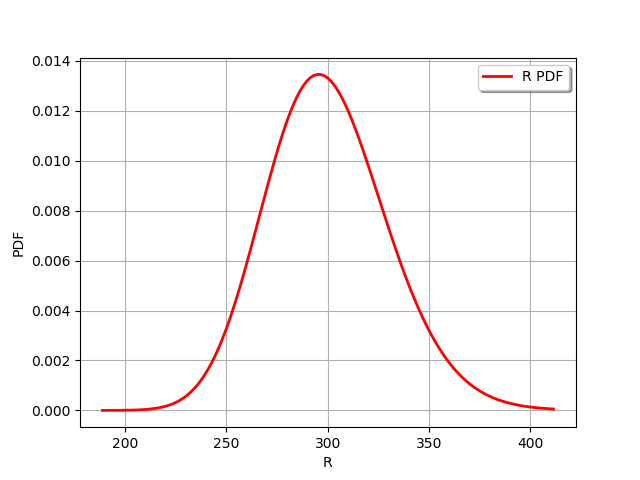

In [4]:
# Create a first marginal : LogNormal distribution 1D, parameterized by
# its mean and standard deviation
R_dist = ot.LogNormalMuSigma(300.0, 30.0, 0.0).getDistribution()
R_dist.setName('Yield strength')
R_dist.setDescription('R')
# Graphical output of the PDF
R_dist.drawPDF()

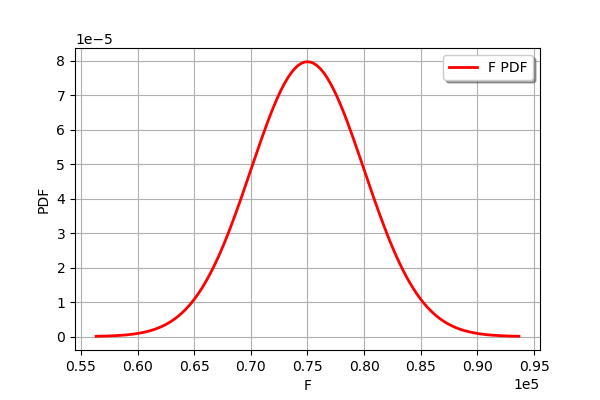

In [5]:
# Create a second marginal : Normal distribution 1D
F_dist = ot.Normal(75000., 5000.)
F_dist.setName('Traction_load')
F_dist.setDescription('F')
# Graphical output of the PDF
F_dist.drawPDF()

In [6]:
# Create a copula : IndependentCopula
aCopula = ot.IndependentCopula(dim)
aCopula.setName('Independent copula')

# Instanciate one distribution object
myDistribution = ot.ComposedDistribution([R_dist, F_dist], aCopula)
myDistribution.setName('myDist')

Given that the copula is independent by default, we can as well use only the first argument of the `ComposedDistribution` class.

In [7]:
myDistribution = ot.ComposedDistribution([R_dist, F_dist])
myDistribution.setName('myDist')

In [8]:
# We create a RandomVector from the Distribution
inputRandomVector = ot.RandomVector(myDistribution)

# We create a composite random vector
outputRandomVector = ot.CompositeRandomVector(limitStateFunction, inputRandomVector)

# We create an Event from this RandomVector
myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 0.0)

## Using Monte Carlo simulations

In [9]:
cv = 0.05
NbSim = 100000

experiment = ot.MonteCarloExperiment()
algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
algoMC.setMaximumOuterSampling(NbSim)
algoMC.setBlockSize(1)
algoMC.setMaximumCoefficientOfVariation(cv)

In [10]:
# For statistics about the algorithm
initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()

Perform the analysis.

In [11]:
algoMC.run()

In [12]:
result = algoMC.getResult()
probabilityMonteCarlo = result.getProbabilityEstimate()
numberOfFunctionEvaluationsMonteCarlo = limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
print('Number of calls to the limit state =', numberOfFunctionEvaluationsMonteCarlo)
print('Pf = ', probabilityMonteCarlo)
print('CV =', result.getCoefficientOfVariation())

Number of calls to the limit state = 12806
Pf =  0.03029829767296579
CV = 0.04999231132448775


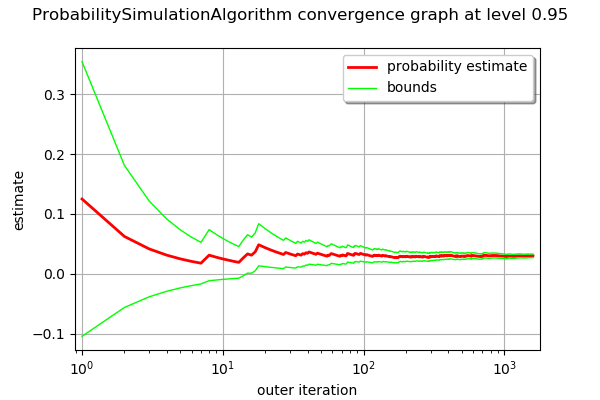

In [13]:
graph = algoMC.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
graph

## Using FORM analysis

In [14]:
# We create a NearestPoint algorithm
myCobyla = ot.Cobyla()
# Resolution options:
eps = 1e-3
myCobyla.setMaximumEvaluationNumber(100)
myCobyla.setMaximumAbsoluteError(eps)
myCobyla.setMaximumRelativeError(eps)
myCobyla.setMaximumResidualError(eps)
myCobyla.setMaximumConstraintError(eps)

In [15]:
# For statistics about the algorithm
initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()

We create a FORM algorithm. The first parameter is a NearestPointAlgorithm. The second parameter is an event. The third parameter is a starting point for the design point research.

In [16]:
algoFORM = ot.FORM(myCobyla, myEvent, myDistribution.getMean())

Perform the analysis.

In [17]:
algoFORM.run()

In [18]:
resultFORM = algoFORM.getResult()
numberOfFunctionEvaluationsFORM = limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
probabilityFORM = resultFORM.getEventProbability()
print('Number of calls to the limit state =', numberOfFunctionEvaluationsFORM)
print('Pf =', probabilityFORM)

Number of calls to the limit state = 98
Pf = 0.02998503189125796


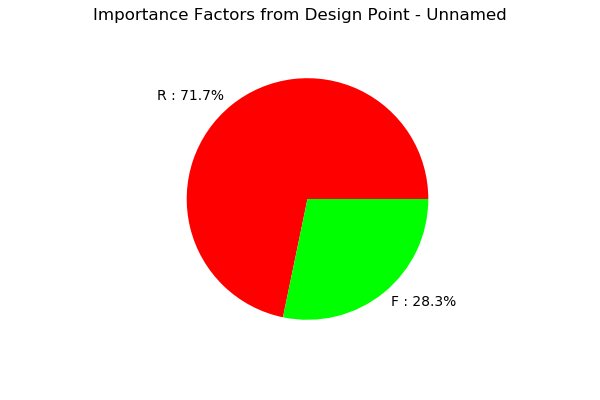

In [19]:
resultFORM.drawImportanceFactors()

## Using Directional sampling

In [20]:
# Resolution options:
cv = 0.05
NbSim = 10000

algoDS = ot.DirectionalSampling(myEvent)
algoDS.setMaximumOuterSampling(NbSim)
algoDS.setBlockSize(1)
algoDS.setMaximumCoefficientOfVariation(cv)

In [21]:
# For statistics about the algorithm
initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()

Perform the analysis.

In [22]:
algoDS.run()

In [23]:
result = algoDS.getResult()
probabilityDirectionalSampling = result.getProbabilityEstimate()
numberOfFunctionEvaluationsDirectionalSampling = limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
print('Number of calls to the limit state =', numberOfFunctionEvaluationsDirectionalSampling)
print('Pf = ', probabilityDirectionalSampling)
print('CV =', result.getCoefficientOfVariation())

Number of calls to the limit state = 8830
Pf =  0.02973057550733805
CV = 0.04991717114882535


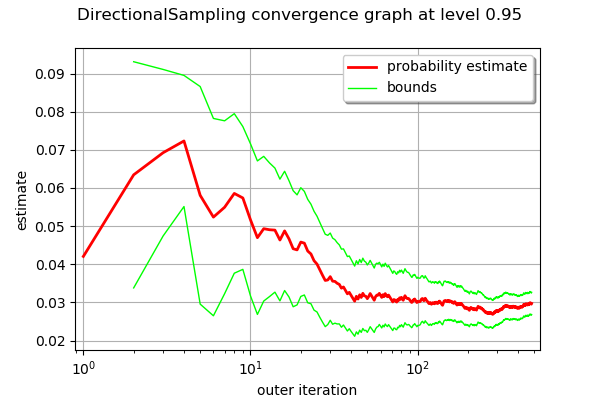

In [24]:
graph = algoDS.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
graph

## Using importance sampling with FORM design point: FORM-IS

The `getStandardSpaceDesignPoint` method returns the design point in the U-space.

In [25]:
standardSpaceDesignPoint = resultFORM.getStandardSpaceDesignPoint()
standardSpaceDesignPoint

class=Point name=Standard Space Design Point dimension=2 values=[-1.59323,0.999915]

The key point is to define the importance distribution in the U-space. To define it, we use a multivariate standard gaussian and configure it so that the center is equal to the design point in the U-space.

In [26]:
dimension = myDistribution.getDimension()
dimension

2

In [27]:
myImportance = ot.Normal(dimension)
myImportance.setMean(standardSpaceDesignPoint)
myImportance

class=Normal name=Normal dimension=2 mean=class=Point name=Standard Space Design Point dimension=2 values=[-1.59323,0.999915] sigma=class=Point name=Unnamed dimension=2 values=[1,1] correlationMatrix=class=CorrelationMatrix dimension=2 implementation=class=MatrixImplementation name=Unnamed rows=2 columns=2 values=[1,0,0,1]

Create the design of experiment corresponding to importance sampling. This generates a `WeightedExperiment` with weights corresponding to the importance distribution.

In [28]:
experiment = ot.ImportanceSamplingExperiment(myImportance)

Create the standard event corresponding to the event. This transforms the original problem into the U-space, with gaussian independent marginals. 

In [29]:
standardEvent = ot.StandardEvent(myEvent)

We then create the simulation algorithm. 

In [30]:
algo = ot.ProbabilitySimulationAlgorithm(standardEvent, experiment)
algo.setMaximumCoefficientOfVariation(cv)
algo.setMaximumOuterSampling(40000)

In [31]:
# For statistics about the algorithm
initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()

In [32]:
algo.run()

In [33]:
# retrieve results
result = algo.getResult()
probabilityFORMIS = result.getProbabilityEstimate()
numberOfFunctionEvaluationsFORMIS = limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
print('Number of calls to the limit state =', numberOfFunctionEvaluationsFORMIS)
print('Pf = ', probabilityFORMIS)
print('CV =', result.getCoefficientOfVariation())

Number of calls to the limit state = 893
Pf =  0.029421203039895906
CV = 0.0499720508995338


## Conclusion

We now compare the different methods in terms of accuracy and speed.

In [34]:
import numpy as np

The following function computes the number of correct base-10 digits in the computed result compared to the exact result.

In [35]:
def computeLogRelativeError(exact, computed):
    logRelativeError = -np.log10(abs(exact - computed) / abs(exact))
    return logRelativeError

The following function will help to print the results.

In [36]:
def printMethodSummary(name, computedProbability, numberOfFunctionEvaluations):
    print("---")
    print(name,":")
    print('Number of calls to the limit state =', numberOfFunctionEvaluations)
    print('Pf = ', computedProbability)
    exactProbability = 0.02919819462483051
    logRelativeError = computeLogRelativeError(exactProbability, computedProbability)
    print("Number of correct digits=%.3f" % (logRelativeError))
    performance = logRelativeError/numberOfFunctionEvaluations
    print("Performance=%.2e (correct digits/evaluation)" % (performance))
    return

In [37]:
printMethodSummary("Monte-Carlo", probabilityMonteCarlo, numberOfFunctionEvaluationsMonteCarlo)
printMethodSummary("FORM", probabilityFORM, numberOfFunctionEvaluationsFORM)
printMethodSummary("DirectionalSampling", probabilityDirectionalSampling, numberOfFunctionEvaluationsDirectionalSampling)
printMethodSummary("FORM-IS", probabilityFORMIS, numberOfFunctionEvaluationsFORMIS)

---
Monte-Carlo :
Number of calls to the limit state = 12806
Pf =  0.03029829767296579
Number of correct digits=1.424
Performance=1.11e-04 (correct digits/evaluation)
---
FORM :
Number of calls to the limit state = 98
Pf =  0.02998503189125796
Number of correct digits=1.569
Performance=1.60e-02 (correct digits/evaluation)
---
DirectionalSampling :
Number of calls to the limit state = 8830
Pf =  0.02973057550733805
Number of correct digits=1.739
Performance=1.97e-04 (correct digits/evaluation)
---
FORM-IS :
Number of calls to the limit state = 893
Pf =  0.029421203039895906
Number of correct digits=2.117
Performance=2.37e-03 (correct digits/evaluation)


We see that all three methods produce the correct probability, with more or less accuracy. In this case, we have found the correct order of magnitude of the probability, i.e. between one and two correct digits. There is, however, significant differences in the performance of the method, in terms of number of function evaluations. 

* The fastest method is the FORM method, which produce more than 1 correct digit with less than 98 function evaluations with a performance equal to $1.60 \times 10^{-2}$ (correct digits/evaluation). A practical limitation is that the FORM method does not produce a confidence interval so that there is no guarantee that the computed probability is correct. 
* The slowest method is the Monte-Carlo simulation, which produces more than 1 correct digit with 12806 function evaluations. This is associated with a very slow performance equal to $1.11 \times 10^{-4}$ (correct digits/evaluation). The interesting point with the Monte-Carlo simulation is that the method produces a confidence interval. 
* The DirectionalSampling method is somewhat in-between the two previous methods.
* The FORM-IS method produces 2 correct digits and has a small number of function evaluations. It has an intermediate performance equal to $2.37\times 10^{-3}$ (correct digits/evaluation). It combines the best of the two worlds: it has the small number of function evaluation of the FORM computation and the confidence interval of the Monte-Carlo simulation. 